# Кастомные загрузчики и готовые реализации

Будем решать задачу классификации картинок и работать с библиотекой PyTorch.
Мы будем использовать предобученную на ImageNet сеть Vgg19 для дообучения на датасете для классификации кошек и собак.

![alt text](https://i.ytimg.com/vi/IiilA0dsciY/maxresdefault.jpg)

## Загрузка датасета

Для загрузки датасета из интернета воспользуемся командами bash. Bash -- язык командной строки linux. В ячейках jupyter notebook можно запускать команды bash, предварительно написав ! в начале ячейки.

In [ ]:
# команда wget скачивает файлы из интернета по ссылке
! wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
# команда unzip разархивирует zip-архив
! unzip cats_and_dogs_filtered.zip

--2022-08-05 20:14:33--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   249MB/s    in 0.3s    

2022-08-05 20:14:33 (249 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog

In [ ]:
# команда ls выводит список файлов в текущей директории
! ls

cats_and_dogs_filtered	cats_and_dogs_filtered.zip  sample_data


In [ ]:
# команда ls ИМЯ_ПАПКИ выводит список файлов в указанной папке
! ls cats_and_dogs_filtered/

train  validation  vectorize.py


In [ ]:
! ls cats_and_dogs_filtered/train

cats  dogs


In [ ]:
# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms
# метрика качества 
from sklearn.metrics import accuracy_score

In [ ]:
# можно из коробки приводить все изображения к единому формату, конвертировать в торч тензор и нормализовывать
transform_train = transforms.Compose([
         transforms.Resize((224, 224)),
         transforms.ToTensor(),
])
# отдельный для теста
transform_val = transforms.Compose([
         transforms.Resize((224, 224)),                           
         transforms.ToTensor(),
])

In [ ]:
# при загрузке сразу указываем как предобрабатывать
train_data = datasets.ImageFolder("cats_and_dogs_filtered/train/", transform=transform_train, )
test_data = datasets.ImageFolder("cats_and_dogs_filtered/validation", transform=transform_val)
# там же в transforms с версии торча 1.8+ появилась и аугментация

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: cats_and_dogs_filtered/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [ ]:
# разбиваем сразу на батчи (обычно берут под максимум, который влезает в память)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle = True, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle = False, pin_memory=True, num_workers=2)

In [ ]:
dataiter = iter(train_loader)
# батч картинок и батч ответов к картинкам
images, labels = dataiter.next()

In [ ]:
# размер картинок
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

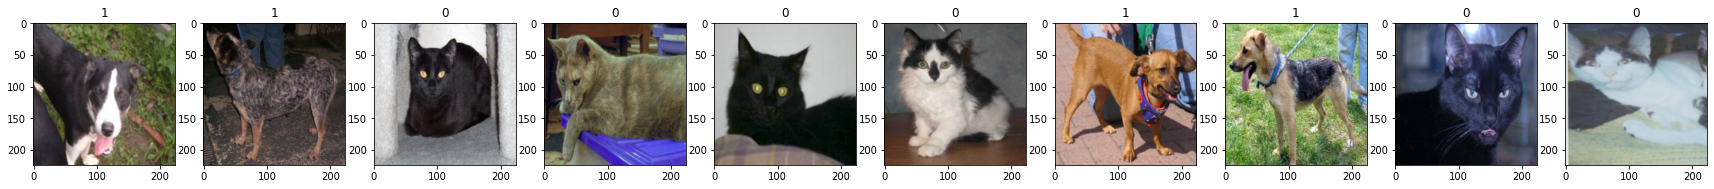

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# посмотрим на пару из них
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
      axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
      axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)

# Обучение 

In [ ]:
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активайии для слоев нейронных сетей
import torch.nn.functional as F
from tqdm.auto import tqdm

device = torch.device('cuda')

In [ ]:
# класс для удобного перевода картинки из 3l объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def train(net, n_epoch=10):
    # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()

    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # acc по test
    best_accuracy = 0
    # обучаем сеть 2 эпохи
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            # так получаем текущий батч
            X_batch, y_batch = batch
            # переносим его на видеопамять
            # если точно уверены, что это гпу - можно написать .cuda()
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # обнуляем веса
            optimizer.zero_grad()

            # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
            # bsckpropagation (вычисление градиентов)
            loss.backward()
            # обновление весов сети
            optimizer.step()

            # выведем текущий loss
            running_loss += loss.item()
            # выведем качество каждые 500 батчей
            if i % 500 == 499:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0

        # менеджер упарвления контекстом торча указывает на то, чтобы не обновлять параметры
        with torch.no_grad():
            accuracy = []
            for batch in test_loader:
                x, y = batch
                # переносим на гпу
                x = x.to(device)
                y = y.to(device)
                # прогнозируем
                y_pred = net(x)
                # loss = loss_fn(y_pred, y)
                # находим accuracy батча с теста
                accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
            # усредняем accuracy всех батчей на тесте
            accuracy = np.mean(np.array(accuracy))
            # если стало лучше - сохраняем на диск и обновляем лучшую метрику
            if accuracy > best_accuracy:
                print('New best model with test acc:', accuracy)
                torch.save(net.state_dict(), './best_model.pt')
                best_accuracy = accuracy

    print('Обучение закончено')
    return net

In [ ]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(3*224*224, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 2)
).to(device)

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

543

In [ ]:
model = train(model)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

New best model with test acc: 0.51171875


  0%|          | 0/63 [00:00<?, ?it/s]

New best model with test acc: 0.5302734375


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Обучение закончено


In [ ]:
labels_net = []
labels_true = []
for images, labels in test_loader:
    labels_true.extend(labels)
    labels_net.extend(model.forward(images.cuda()).detach().cpu().numpy())

In [ ]:
accuracy_score(labels_true, np.argmax(np.array(labels_net), axis=1))

0.5

# Кастомные даталоадеры

Код ниже скачивает данные НеМнист - набор букв

In [ ]:
import os
from glob import glob

import numpy as np
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split

def load_notmnist(
    path='./notMNIST_small',
    letters='ABCDEFGHIJ',
    img_shape=(28,28),
    test_size=0.25,
    one_hot=False,
):
    # download data if it's missing. If you have any problems, go to the urls and load it manually.
    if not os.path.exists(path):
        if not os.path.exists('./notMNIST_small.tar.gz'):
            print("Downloading data...")
            assert os.system('curl http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz > notMNIST_small.tar.gz') == 0
        print("Extracting ...")
        assert os.system('tar -zxvf notMNIST_small.tar.gz > untar_notmnist.log') == 0

    data,labels = [],[]
    print("Parsing...")
    for img_path in glob(os.path.join(path,'*/*')):
        class_i = img_path.split(os.sep)[-2]
        if class_i not in letters: continue
        try:
            data.append(imread(img_path))
            labels.append(class_i,)
        except:
            print("found broken img: %s [it's ok if <10 images are broken]" % img_path)

    data = np.stack(data)[:,None].astype('float32')
    data = (data - np.mean(data)) / np.std(data)

    #convert classes to ints
    letter_to_i = {l:i for i,l in enumerate(letters)}
    labels = np.array(list(map(letter_to_i.get, labels)))

    if one_hot:
        labels = (np.arange(np.max(labels) + 1)[None,:] == labels[:, None]).astype('float32')

    #split into train/test
    if test_size == 0:
        X_train, X_test, y_train, y_test = data, [], labels, []
    else:
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=42)

    print("Done")
    return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = load_notmnist()
type(X_train)

Extracting ...
Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


numpy.ndarray

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms

Хороший пример:

https://albumentations.ai/docs/examples/pytorch_classification/

In [ ]:
# imageFolder не сможет нормально обработать выборки, которые не помещаются в оперативку
class DatasetMNIST(Dataset):
    def __init__(self, path='./notMNIST_small', letters='ABCDEFGHIJ', transform=None):
        # мы можем использовать imageFolder для загрузки какой-то части датасета
        self.data, self.labels, _ ,_  = load_notmnist(path=path, letters=letters, test_size=0)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index].transpose(1, 2, 0) # формат каналов торча
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
full_dataset = DatasetMNIST('./notMNIST_small', 'AB', transform=None)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [ ]:
# встроенный метод получает нужнуй элемент по индексу
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [ ]:
a = torchvision.transforms.ToTensor()

a(img).shape

torch.Size([1, 28, 28])

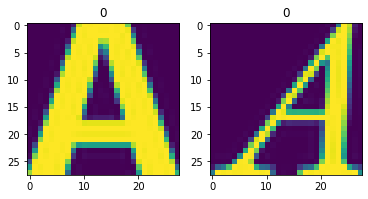

In [ ]:
# отобразим пару букв
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28,28]))
    plt.title(str(full_dataset[inds[i]][1]))

In [ ]:
# создаем привычный загрузчик
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)

In [ ]:

# мы можем использовать dataloader в качестве итератора с помощью функции iter()
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>


In [ ]:
# мы можем просматривать изображения и метки пакетного размера, извлекая данные методом .next()
images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 28, 28, 1])
labels shape on batch size = torch.Size([8])


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


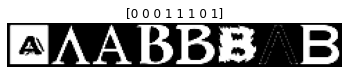

In [ ]:
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

с версии 1.9 можно НА ХОДУ применять целый спектр встроенный преобразований
https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

In [ ]:
# конвертируем в тензор
train_dataset_with_transform = DatasetMNIST(
    transform=torchvision.transforms.ToTensor()
)

# например обрезать по центру
# transforms.Compose([
#     transforms.CenterCrop(10),
#     # https://github.com/albumentations-team/albumentations
#     transforms.ToTensor(),
# ])

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [ ]:
img, lab = train_dataset_with_transform.__getitem__(0)

print('image shape at the first row : {}'.format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [ ]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = train_iter_tr.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


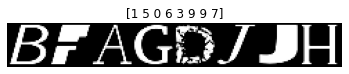

In [ ]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

In [ ]:
class Flatten():
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [ ]:
a = Flatten()

In [ ]:
a(img).shape

torch.Size([784])

In [ ]:
new_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Flatten()
])

In [ ]:
# взять случайные 20 процентов индексов из датасета
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [ ]:
dataset = DatasetMNIST(
    './notMNIST_small',
    transform=new_transform
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f'\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}')

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


 dataset size: 3744, labels: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f'  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

  training size: 2996
validation size: 748


In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)

In [ ]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>
images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


In [ ]:
device=torch.device('cuda')

model = nn.Sequential(
    nn.Linear(784, 10),
    nn.Sigmoid(),
)
model = model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
import time

def train_model(model, train_loader, test_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                ep_val_loss.append(loss.item())
                y_pred = model(X_batch)
                y_pred = y_pred.max(1)[1].data
                ep_val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [ ]:
n_epochs = 30

loss_func = torch.nn.CrossEntropyLoss()
train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.878s
	  training loss: 1.845301
	validation loss: 1.723594
	validation accuracy: 0.746
Epoch 2 of 30 took 0.871s
	  training loss: 1.697919
	validation loss: 1.675147
	validation accuracy: 0.749
Epoch 3 of 30 took 0.864s
	  training loss: 1.671344
	validation loss: 1.622176
	validation accuracy: 0.743
Epoch 4 of 30 took 0.851s
	  training loss: 1.649698
	validation loss: 1.596873
	validation accuracy: 0.747
Epoch 5 of 30 took 0.826s
	  training loss: 1.641338
	validation loss: 1.602924
	validation accuracy: 0.714
Epoch 6 of 30 took 0.843s
	  training loss: 1.634176
	validation loss: 1.587726
	validation accuracy: 0.705
Epoch 7 of 30 took 0.845s
	  training loss: 1.629610
	validation loss: 1.783729
	validation accuracy: 0.711
Epoch 8 of 30 took 0.863s
	  training loss: 1.625142
	validation loss: 1.643203
	validation accuracy: 0.710
Epoch 9 of 30 took 0.849s
	  training loss: 1.621081
	validation loss: 1.535651
	validation accuracy: 0.699
Epoch 10 of 30 took 0.841s
	

In [ ]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

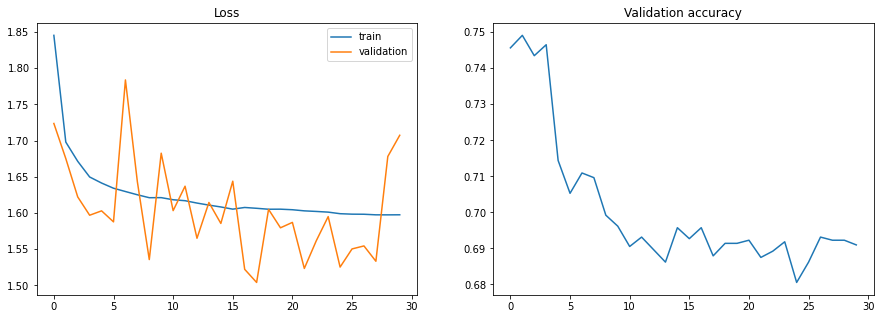

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [ ]:
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.970s
	  training loss: 1.835611
	validation loss: 1.798356
	validation accuracy: 0.442
Epoch 2 of 30 took 0.989s
	  training loss: 1.803303
	validation loss: 1.688298
	validation accuracy: 0.454
Epoch 3 of 30 took 0.971s
	  training loss: 1.835325
	validation loss: 1.804852
	validation accuracy: 0.369
Epoch 4 of 30 took 0.992s
	  training loss: 1.943329
	validation loss: 2.068985
	validation accuracy: 0.310
Epoch 5 of 30 took 0.954s
	  training loss: 1.971194
	validation loss: 1.893356
	validation accuracy: 0.245
Epoch 6 of 30 took 0.956s
	  training loss: 2.021645
	validation loss: 2.081719
	validation accuracy: 0.221
Epoch 7 of 30 took 0.960s
	  training loss: 2.097637
	validation loss: 2.034431
	validation accuracy: 0.171
Epoch 8 of 30 took 0.987s
	  training loss: 2.153407
	validation loss: 2.289154
	validation accuracy: 0.163
Epoch 9 of 30 took 0.967s
	  training loss: 2.173539
	validation loss: 2.303970
	validation accuracy: 0.161
Epoch 10 of 30 took 0.957s
	

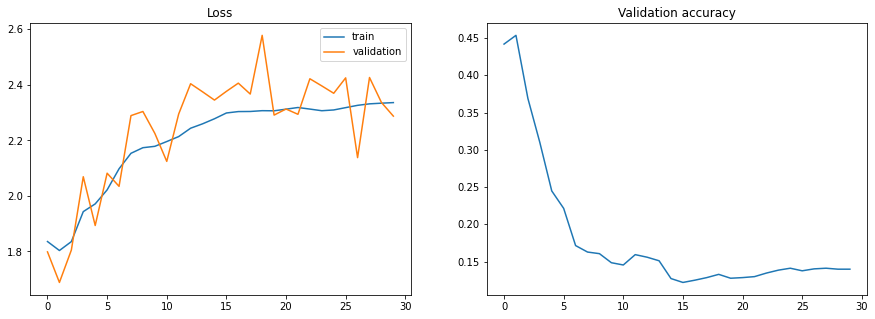

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [ ]:
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.Dropout(p=0.6),
    nn.BatchNorm1d(200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Dropout(p=0.6),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 1.025s
	  training loss: 2.196938
	validation loss: 2.145408
	validation accuracy: 0.748
Epoch 2 of 30 took 1.037s
	  training loss: 2.098492
	validation loss: 2.034467
	validation accuracy: 0.817
Epoch 3 of 30 took 1.021s
	  training loss: 2.075498
	validation loss: 2.016072
	validation accuracy: 0.829
Epoch 4 of 30 took 1.030s
	  training loss: 2.065643
	validation loss: 2.000112
	validation accuracy: 0.843
Epoch 5 of 30 took 0.997s
	  training loss: 2.044848
	validation loss: 2.087222
	validation accuracy: 0.842
Epoch 6 of 30 took 1.011s
	  training loss: 2.039188
	validation loss: 1.976304
	validation accuracy: 0.849
Epoch 7 of 30 took 1.026s
	  training loss: 2.034627
	validation loss: 2.067186
	validation accuracy: 0.842
Epoch 8 of 30 took 1.013s
	  training loss: 2.039034
	validation loss: 2.037847
	validation accuracy: 0.846
Epoch 9 of 30 took 1.016s
	  training loss: 2.035918
	validation loss: 2.105116
	validation accuracy: 0.855
Epoch 10 of 30 took 1.025s
	

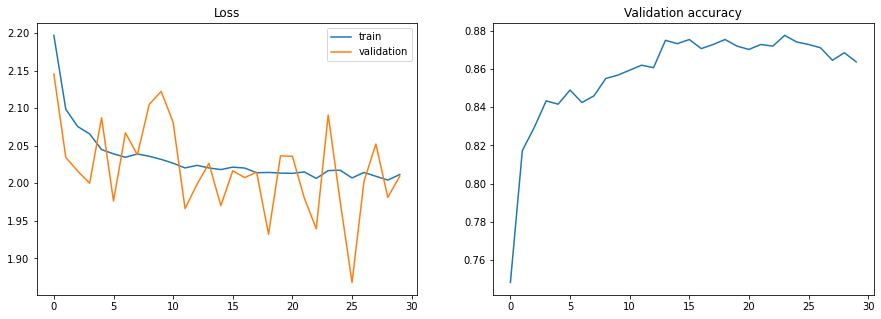

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

# Model checkpointing

Сохранение для продолжение обучения предполагает сохранение состояний оптимизатора

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)